In [1]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-h7lo5oib
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-h7lo5oib
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1086740 sha256=b821c8055d2c96a7da33852c28e68d7978d0f6179c6b7f8d31d1a55995c857bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-60u30iss/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0


In [2]:
import os
import h5py
import fitsio
import numpy as np 
import scipy as sp
import astropy.table as atable
import astropy.units as u
import matplotlib.pyplot as plt

from bgs_sv import sv1

In [3]:
dir_sky = '/global/cfs/cdirs/desi/users/chahah/sky/'

def read_BOSS_skies(): 
    ''' read sky fibers from BOSS
    '''
    f_boss = os.path.join(dir_sky, 'Bright_BOSS_Sky_blue.fits')
    boss = fitsio.read(f_boss)    
    f_red = os.path.join(dir_sky, 'Bright_BOSS_Sky_red.fits')
    red = fitsio.read(f_red)
    
    sky_boss = {} 
    sky_boss['airmass'] = boss['AIRMASS']
    sky_boss['moon_ill'] = boss['MOON_ILL']
    sky_boss['moon_alt'] = boss['MOON_ALT']
    sky_boss['moon_sep'] = boss['MOON_SEP']

    sky_boss['sun_alt'] = boss['SUN_ALT']
    sky_boss['sun_sep'] = boss['SUN_SEP']
        
    boss_fiber_area = np.pi

    sky_boss['wave_b'] = boss['WAVE'] * 10. # convert to Angstroms
    sky_boss['sky_b'] = boss['SKY'] / boss_fiber_area
    sky_boss['wave_r'] = red['WAVE'] * 10.
    sky_boss['sky_r'] = red['SKY'] / boss_fiber_area
    return sky_boss

In [4]:
boss_skies = read_BOSS_skies()

# get exposures where sun_alt > -18 to estimate twilight contribution
twilight = boss_skies['sun_alt'] > -18.
print('%i of %i BOSS exposures have sun altitude > -18.' % (np.sum(twilight), len(boss_skies['sun_alt'])))

for k in boss_skies.keys():
    boss_skies[k] = boss_skies[k][twilight]

154 of 1144 BOSS exposures have sun altitude > -18.


No handles with labels found to put in legend.


(-20.0, -12.0)

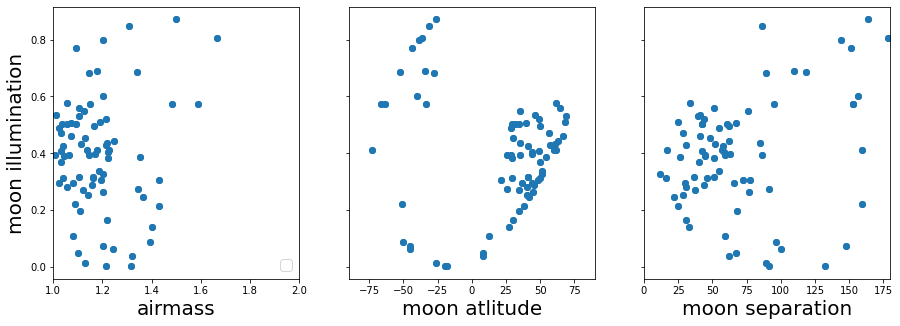

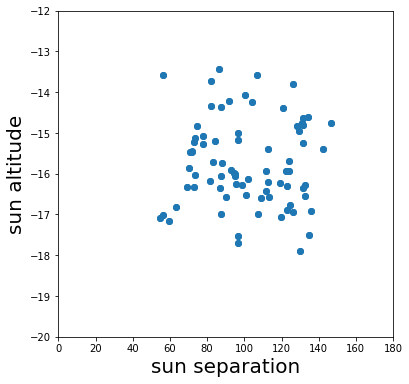

In [5]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c='C0')
sub.legend(loc='lower right', frameon=True, handletextpad=0, markerscale=2, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c='C0')

sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c='C0', label='BOSS')

sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])


fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(boss_skies['sun_sep'], boss_skies['sun_alt'], c='C0', label='BOSS')

sub.set_xlabel('sun separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_ylabel('sun altitude', fontsize=20)
sub.set_ylim(-20., -12.)

In [6]:
# get model sky brightness at 5000A from dark sky + scattered moon light (excluding twilight)
model_Iskies5000 = sv1._sky_brightness_5000A_model_notwilight(boss_skies['airmass'], boss_skies['moon_ill'], boss_skies['moon_alt'], boss_skies['moon_sep'])

In [7]:
from scipy.ndimage import gaussian_filter1d
def smooth_sky(sky, smoothing=100.): 
    return gaussian_filter1d(sky, smoothing)

In [8]:
# sky brightness for BOSS
boss_Iskies5000 = []
for _w, Isky in zip(boss_skies['wave_b'], boss_skies['sky_b']): 
    Ismooth = smooth_sky(Isky, smoothing=800) # BOSS has 8x smaller binning
    boss_Iskies5000.append(np.interp(5000, _w, Ismooth))

(0.0, 12.0)

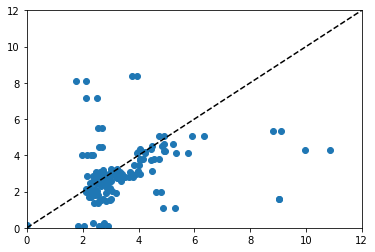

In [9]:
plt.scatter(boss_Iskies5000, model_Iskies5000)
plt.plot([0., 12.], [0., 12.], c='k', ls='--')
plt.xlim(0., 12)
plt.ylim(0., 12)

In [10]:
boss_Iskies_twilight = boss_Iskies5000 - model_Iskies5000 #np.clip(boss_Iskies5000 - model_Iskies5000, 0, None)

(0.0, 8.0)

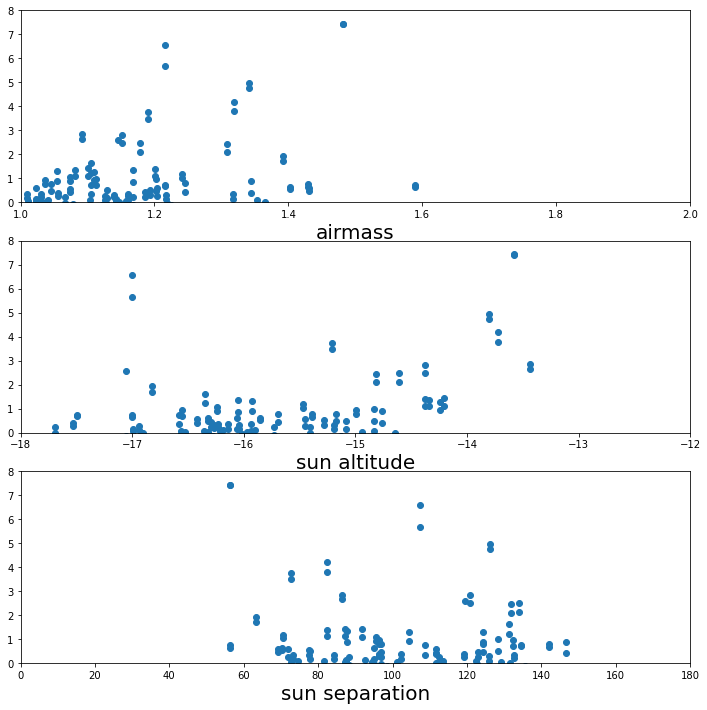

In [11]:
fig = plt.figure(figsize=(12,12))
sub = fig.add_subplot(311)
sub.scatter(boss_skies['airmass'], boss_Iskies_twilight)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylim(0., 8)

sub = fig.add_subplot(312)
sub.scatter(boss_skies['sun_alt'], boss_Iskies_twilight)
sub.set_xlabel('sun altitude', fontsize=20)
sub.set_xlim(-18, -12)
sub.set_ylim(0., 8)

sub = fig.add_subplot(313)
sub.scatter(boss_skies['sun_sep'], boss_Iskies_twilight)
sub.set_xlabel('sun separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_ylim(0., 8)

(-20.0, -12.0)

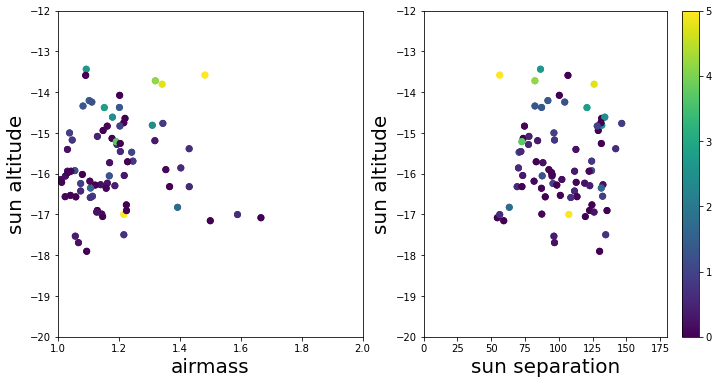

In [12]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(boss_skies['airmass'], boss_skies['sun_alt'], c=boss_Iskies_twilight, vmin=0., vmax=5)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('sun altitude', fontsize=20)
sub.set_ylim(-20., -12.)

sub = fig.add_subplot(122)
_plt = sub.scatter(boss_skies['sun_sep'], boss_skies['sun_alt'], c=boss_Iskies_twilight, vmin=0., vmax=5)
fig.colorbar(_plt)
sub.set_xlabel('sun separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_ylabel('sun altitude', fontsize=20)
sub.set_ylim(-20., -12.)

In [13]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from itertools import chain, combinations_with_replacement

In [14]:
theta_train = np.vstack([boss_skies['airmass'], boss_skies['sun_alt'], boss_skies['sun_sep']]).T
Isky_train = boss_Iskies_twilight

theta_train = theta_train[boss_Iskies_twilight > 0]
Isky_train = Isky_train[boss_Iskies_twilight > 0]

regmodels_fsky, scores = [], [] 
for n_order in range(1, 5): 
    # we use Ridge instead of LinearRegression to regularize the coefficients
    regress_fsky = Pipeline([('poly', PolynomialFeatures(n_order)),
                             ('linear', Ridge(alpha=1., fit_intercept=False))]) 
    regress_fsky.fit(theta_train, Isky_train)
    regmodels_fsky.append(regress_fsky)
    
    # evaluate the model using crossvalidation
    _scores = cross_val_score(regress_fsky, theta_train, Isky_train, scoring="neg_mean_squared_error")
    #_scores = [-np.sum((Isky_train - regress_fsky.predict(theta_train))**2)]
    
    print('%i order: score=%f' % (n_order, -np.mean(_scores)))
    scores.append(-np.mean(_scores))
norder = np.argmin(scores)+1
regress_fsky = regmodels_fsky[np.argmin(scores)]


1 order: score=2.080315
2 order: score=2.773678
3 order: score=2.415472
4 order: score=13.371005


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.67637e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.97459e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.3086e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.16424e-19): result may not b

In [15]:
steps = regress_fsky.get_params()
skymodel_coeff = steps['linear'].coef_
skymodel_intercept = steps['linear'].intercept_

In [16]:
print(norder)

1


In [17]:
skymodel_coeff

array([2.00474700e+00, 3.19827604e+00, 3.13212960e-01, 2.69673079e-03])

In [18]:
def skymodel_twi(airmass, sun_alt, sun_sep):
    ''' 
    '''
    theta = np.atleast_2d(np.array([airmass, sun_alt, sun_sep]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(3), i) for i in range(0, norder+1))
    theta_transform = np.empty((theta.shape[0], len(skymodel_coeff)))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)

    return np.dot(theta_transform, skymodel_coeff.T) + skymodel_intercept

In [19]:
Isky5000_twilight_reg = skymodel_twi(boss_skies['airmass'], boss_skies['sun_alt'], boss_skies['sun_sep'])

(0.0, 8.0)

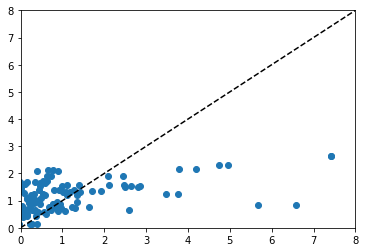

In [20]:
plt.scatter(boss_Iskies_twilight, Isky5000_twilight_reg)
plt.plot([0., 8.], [0., 8.], c='k', ls='--')
plt.xlim(0., 8)
plt.ylim(0., 8)

(0.0, 8.0)

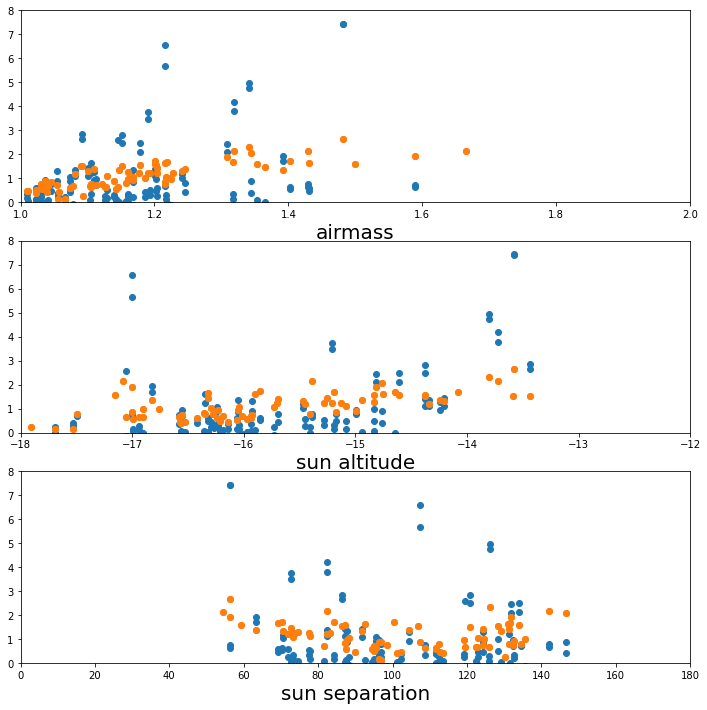

In [21]:
fig = plt.figure(figsize=(12,12))
sub = fig.add_subplot(311)
sub.scatter(boss_skies['airmass'], boss_Iskies_twilight)
sub.scatter(boss_skies['airmass'], Isky5000_twilight_reg)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylim(0., 8)

sub = fig.add_subplot(312)
sub.scatter(boss_skies['sun_alt'], boss_Iskies_twilight)
sub.scatter(boss_skies['sun_alt'], Isky5000_twilight_reg)

sub.set_xlabel('sun altitude', fontsize=20)
sub.set_xlim(-18, -12)
sub.set_ylim(0., 8)

sub = fig.add_subplot(313)
sub.scatter(boss_skies['sun_sep'], boss_Iskies_twilight)
sub.scatter(boss_skies['sun_sep'], Isky5000_twilight_reg)

sub.set_xlabel('sun separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_ylim(0., 8)